In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

df_confirmed = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
                sep=',',encoding='ISO8859-1')

df_deceased = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
                sep=',',encoding='ISO8859-1')


In [2]:
### m UK count includes all their provinces

df_deceased[df_deceased['Country/Region'] == 'United Kingdom']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
217,Bermuda,United Kingdom,32.3078,-64.7505,0,0,0,0,0,0,...,6,6,7,7,7,7,7,7,7,7
218,Cayman Islands,United Kingdom,19.3133,-81.2546,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
219,Channel Islands,United Kingdom,49.3723,-2.3644,0,0,0,0,0,0,...,40,41,41,41,41,40,40,40,41,41
220,Gibraltar,United Kingdom,36.1408,-5.3536,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221,Isle of Man,United Kingdom,54.2361,-4.5481,0,0,0,0,0,0,...,21,22,22,22,23,23,23,23,23,23
222,Montserrat,United Kingdom,16.7425,-62.1874,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,26771,27510,28131,28446,28734,29427,30076,30615,31241,31587
249,Anguilla,United Kingdom,18.2206,-63.0686,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
250,British Virgin Islands,United Kingdom,18.4207,-64.6400,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
251,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [3]:
df_confirmed.tail(40)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
226,NaN,Uzbekistan,41.377500,64.585300,0,0,0,0,0,0,...,2039,2086,2118,2149,2189,2207,2233,2298,2325,2349
227,NaN,Venezuela,6.423800,-66.589700,0,0,0,0,0,0,...,333,335,345,357,357,361,379,381,388,402
228,NaN,Vietnam,16.000000,108.000000,0,2,2,2,2,2,...,270,270,270,271,271,271,271,288,288,288
229,NaN,Zambia,-15.416700,28.283300,0,0,0,0,0,0,...,106,109,119,124,137,138,146,153,167,252
230,NaN,Zimbabwe,-20.000000,30.000000,0,0,0,0,0,0,...,40,40,34,34,34,34,34,34,34,35
231,Diamond Princess,Canada,0.000000,0.000000,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
232,NaN,Dominica,15.415000,-61.371000,0,0,0,0,0,0,...,16,16,16,16,16,16,16,16,16,16
233,NaN,Grenada,12.116500,-61.679000,0,0,0,0,0,0,...,20,20,21,21,21,21,21,21,21,21
234,NaN,Mozambique,-18.665695,35.529562,0,0,0,0,0,0,...,76,79,79,80,80,81,81,81,82,87
235,NaN,Syria,34.802075,38.996815,0,0,0,0,0,0,...,43,44,44,44,44,44,45,45,47,47


In [4]:
countries = df_confirmed['Country/Region'].unique()
sorted(countries)

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',

In [5]:

all_countries = pd.DataFrame()

for c in countries:
    temp = df_confirmed[df_confirmed['Country/Region'] == c]
    temp = temp.groupby('Country/Region')
    temp = temp.sum().iloc[:,4:]
    temp = temp.T

    all_countries = pd.concat([all_countries,temp],axis=1)

def create_country_df(country):
    
    confirmed = all_countries[country]
    confirmed.index = pd.to_datetime(confirmed.index)
    factor = confirmed / confirmed.shift()
    data = pd.concat([confirmed,factor],axis=1)
    data.columns = ['confirmed','factor']
    data.factor.replace(np.inf,np.nan,inplace=True)
    data['inc'] = data['confirmed'] - data['confirmed'].shift()
    return data

confirmed_dict = dict()

for c in countries:
    confirmed_dict[c] = create_country_df(c)
    
thai = confirmed_dict['Thailand']
swe = confirmed_dict['Sweden']
ita = confirmed_dict['Italy']
korea = confirmed_dict['Korea, South']
us = confirmed_dict['US']
spain = confirmed_dict['Spain']
ger = confirmed_dict['Germany']

ita


,confirmed,factor,inc
2020-01-24,0,NaN,NaN
2020-01-25,0,NaN,0.0
2020-01-26,0,NaN,0.0
2020-01-27,0,NaN,0.0
2020-01-28,0,NaN,0.0
...,...,...,...
2020-05-05,213013,1.005072,1075.0
2020-05-06,214457,1.006779,1444.0
2020-05-07,215858,1.006533,1401.0
2020-05-08,217185,1.006148,1327.0


In [6]:
global_confirmed = df_confirmed.iloc[:,5:].sum()


In [7]:
global_deceased = df_deceased.iloc[:,5:].sum()
global_deceased.index = pd.to_datetime(global_deceased.index)
global_confirmed = df_confirmed.iloc[:,5:].sum()
global_confirmed.index = pd.to_datetime(global_confirmed.index)

global_data = pd.DataFrame(global_confirmed,columns=['confirmed'])
global_data['factor'] = global_data['confirmed'] / global_data['confirmed'].shift()
global_data['inc'] = global_data['confirmed'] - global_data['confirmed'].shift()
global_data['dead'] = global_deceased
global_data['dead_factor'] = global_data['dead'] / global_data['dead'].shift()
global_data['dead_inc'] = global_data['dead'] - global_data['dead'].shift()
global_data['pct_dead'] = 100 * global_data['dead'] /global_data['confirmed']
global_data.index = pd.to_datetime(global_data.index)
global_data.to_pickle('global_data.pkl')
global_data
global_data.describe()

,confirmed,factor,inc,dead,dead_factor,dead_inc,pct_dead
count,1.080000e+02,107.000000,107.000000,108.000000,107.000000,107.000000,108.000000
mean,9.882866e+05,1.090907,37601.448598,65384.333333,1.099067,2610.214953,4.504002
std,1.252963e+06,0.127728,36971.814772,89578.745421,0.110095,2840.967856,1.845564
min,6.540000e+02,1.004913,287.000000,18.000000,1.001780,2.000000,2.040890
25%,7.551325e+04,1.025641,2319.000000,2093.250000,1.029675,93.500000,2.898010
50%,1.893580e+05,1.046885,16867.000000,7553.000000,1.069225,806.000000,3.986712
75%,1.852648e+06,1.105309,75945.000000,121280.000000,1.123845,5564.000000,6.578998
max,4.024009e+06,1.905706,99120.000000,279311.000000,1.615385,8858.000000,7.176684


/usr/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


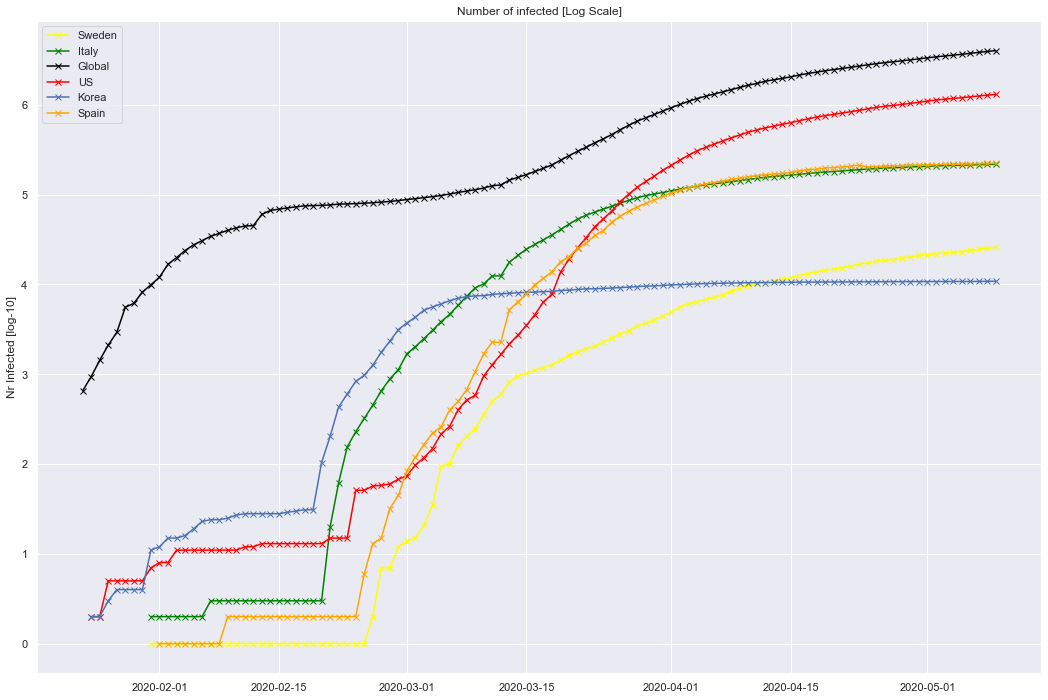

In [8]:
global_conf = np.log10(global_confirmed)

swe_conf = swe.loc[swe['confirmed'] > 0]
swe_conf = np.log10(swe_conf['confirmed'])
ita_conf = ita.loc[ita['confirmed'] > 0]
ita_conf = np.log10(ita_conf['confirmed'])
us_conf = us.loc[us['confirmed'] > 0]
us_conf = np.log10(us_conf['confirmed'])
korea_conf = korea.loc[korea['confirmed'] > 0]
korea_conf = np.log10(korea_conf['confirmed'])
spain_conf = spain.loc[spain['confirmed'] > 0]
spain_conf = np.log10(spain['confirmed'])

plt.figure(figsize=(18,12))
plt.title('Number of infected [Log Scale]')
plt.plot(swe_conf,'x-',color='yellow',label='Sweden')
plt.plot(ita_conf,'x-',color='green',label='Italy')
plt.plot(global_conf,'x-',color='black',label='Global')
plt.plot(us_conf,'x-',color='red',label='US')
plt.plot(korea_conf,'x-',color='b',label='Korea')
plt.plot(spain_conf,'x-',color='orange',label='Spain')
plt.ylabel('Nr Infected [log-10]')
plt.legend(loc='upper left')
plt.savefig('corona_evolution_countries_log.jpg',format='jpg')

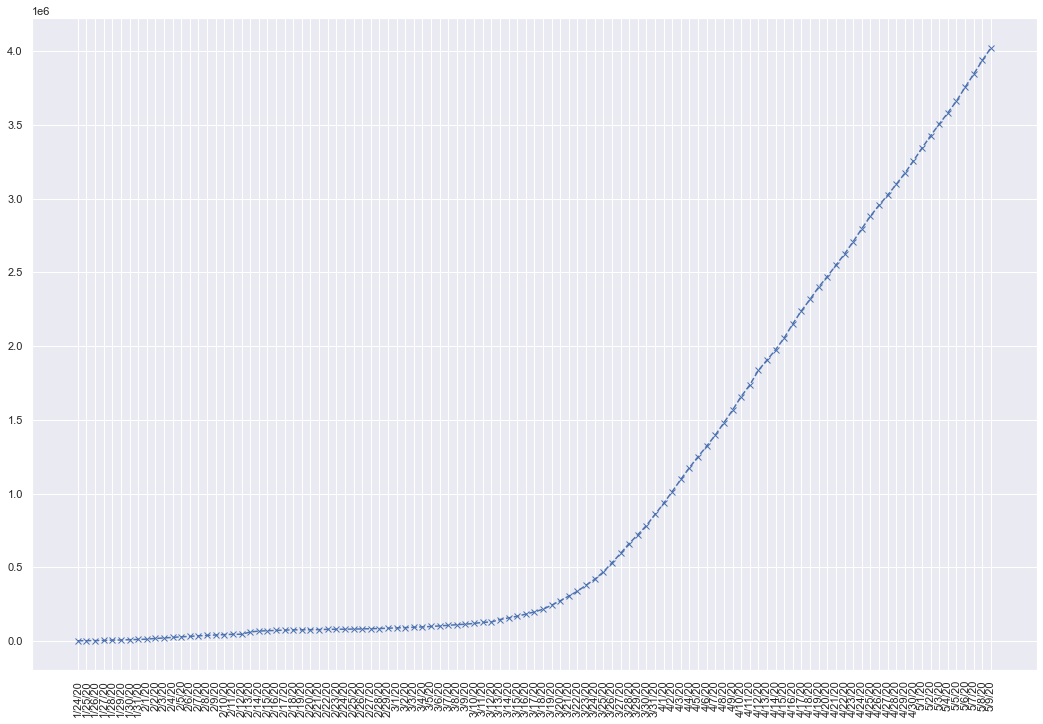

In [9]:
global_series = all_countries.sum(axis=1)
_= plt.figure(figsize=(18,12))
_= plt.plot(global_series,'x--')

_= plt.xticks(rotation=90)



In [10]:


countries_deceased = countries
all_countries_deceased = pd.DataFrame()

for c in countries_deceased:
    temp = df_deceased[df_deceased['Country/Region'] == c]
    temp = temp.groupby('Country/Region')
    temp = temp.sum().iloc[:,4:]
    temp = temp.T

    all_countries_deceased = pd.concat([all_countries_deceased,temp],axis=1)
    

def create_deceased_df(country):
    process = True
    try:
        deceased = all_countries_deceased[country]
    except KeyError:
        print ('cant find {} in deaths'.format(country))
        process = False
        
    if process:
        deceased.index = pd.to_datetime(deceased.index)
        factor = deceased / deceased.shift()

        data = pd.concat([deceased,factor],axis=1)
        data.columns = ['deceased','dead_factor']
        data.dead_factor.replace(np.inf,np.nan,inplace=True)
        data['dead_inc'] = data['deceased'] - data['deceased'].shift()
        return data

deceased_dict = dict()

for c in countries_deceased:
    
    deceased_dict[c] = create_deceased_df(c)




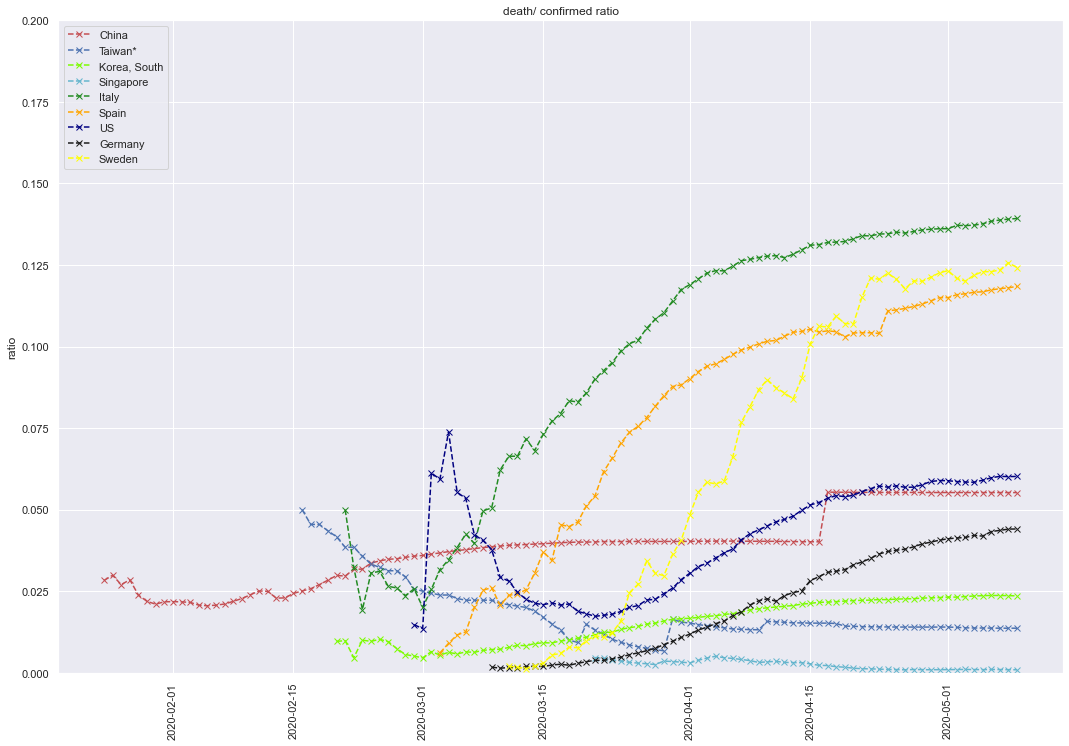

In [11]:
country_data = dict()

for c in countries:
    country_data[c] = pd.concat([confirmed_dict[c],deceased_dict[c]],axis=1)
    country_data[c]['pct_dead'] = 100 * country_data[c]['deceased'] / country_data[c]['confirmed']
    country_data[c]['conf_over_dead'] = country_data[c]['confirmed'] / country_data[c]['deceased']
    country_data[c]['conf_over_dead'] = country_data[c]['conf_over_dead'].replace(np.inf,np.nan)
    country_data[c]['dead_conf_ratio'] =  country_data[c]['dead_factor'] / country_data[c]['factor']
    

import pickle

with open ('country_data.pkl','wb') as f:
    pickle.dump(country_data,f,protocol=pickle.HIGHEST_PROTOCOL)

countries_of_interest = ['China','Taiwan*','Korea, South','Singapore',
                         'Italy','Spain','US','Germany','Sweden']

colors = ['r','b','lawngreen','c',
          'forestgreen','orange','navy','k','yellow']

plt.figure(figsize=(18,12))
plt.title('death/ confirmed ratio')

i = 0
for c in countries_of_interest:
    country = country_data[c]
    mask = country['deceased'] >= 1
    country = country[mask]
    plt.plot(country['deceased'] / country['confirmed'],'x--',
             color=colors[i],label=c)
    i += 1      

plt.ylabel('ratio')
plt.xticks(rotation=90)
plt.ylim([0,0.20])
plt.legend(loc='upper left')
#plt.yscale('log')

plt.savefig('corona_dead_conf_ratio.jpg',format='jpg')


In [12]:
country_data['Sweden'].tail(40)

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
2020-03-31,4435,1.101043,407.0,180,1.232877,34.0,4.058625,24.638889,1.119736
2020-04-01,4947,1.115445,512.0,239,1.327778,59.0,4.831211,20.698745,1.190357
2020-04-02,5568,1.125531,621.0,308,1.288703,69.0,5.531609,18.077922,1.144974
2020-04-03,6131,1.101114,563.0,358,1.162338,50.0,5.839178,17.125698,1.055602
2020-04-04,6443,1.050889,312.0,373,1.041899,15.0,5.789229,17.273458,0.991446
2020-04-05,6830,1.060065,387.0,401,1.075067,28.0,5.871157,17.032419,1.014152
2020-04-06,7206,1.055051,376.0,477,1.189526,76.0,6.619484,15.106918,1.127458
2020-04-07,7693,1.067583,487.0,591,1.238994,114.0,7.682309,13.016920,1.160560
2020-04-08,8419,1.094372,726.0,687,1.162437,96.0,8.160114,12.254731,1.062196
2020-04-09,9141,1.085758,722.0,793,1.154294,106.0,8.675200,11.527112,1.063122


In [13]:
country_data['US'].tail(60)

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
2020-03-11,1281,1.335766,322.0,36,1.285714,8.0,2.810304,35.583333,0.962529
2020-03-12,1663,1.298205,382.0,41,1.138889,5.0,2.465424,40.560976,0.877280
2020-03-13,2179,1.310283,516.0,49,1.195122,8.0,2.248738,44.469388,0.912110
2020-03-14,2727,1.251492,548.0,58,1.183673,9.0,2.126879,47.017241,0.945810
2020-03-15,3499,1.283095,772.0,73,1.258621,15.0,2.086310,47.931507,0.980926
2020-03-16,4632,1.323807,1133.0,99,1.356164,26.0,2.137306,46.787879,1.024443
2020-03-17,6421,1.386226,1789.0,133,1.343434,34.0,2.071328,48.278195,0.969131
2020-03-18,7783,1.212116,1362.0,164,1.233083,31.0,2.107157,47.457317,1.017297
2020-03-19,13747,1.766285,5964.0,258,1.573171,94.0,1.876773,53.282946,0.890666
2020-03-20,19273,1.401979,5526.0,349,1.352713,91.0,1.810823,55.223496,0.964860


In [14]:
country_data['Spain'].tail(40)

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
2020-03-31,95923,1.090579,7967.0,8464,1.096941,748.0,8.823744,11.333058,1.005834
2020-04-01,104118,1.085433,8195.0,9387,1.109050,923.0,9.015732,11.091723,1.021758
2020-04-02,112065,1.076327,7947.0,10348,1.102376,961.0,9.233927,10.829629,1.024202
2020-04-03,119199,1.063659,7134.0,11198,1.082141,850.0,9.394374,10.644669,1.017376
2020-04-04,126168,1.058465,6969.0,11947,1.066887,749.0,9.469121,10.560643,1.007957
2020-04-05,131646,1.043418,5478.0,12641,1.058090,694.0,9.602267,10.414208,1.014061
2020-04-06,136675,1.038201,5029.0,13341,1.055375,700.0,9.761112,10.244734,1.016542
2020-04-07,141942,1.038537,5267.0,14045,1.052770,704.0,9.894887,10.106230,1.013705
2020-04-08,148220,1.044229,6278.0,14792,1.053186,747.0,9.979760,10.020281,1.008577
2020-04-09,153222,1.033747,5002.0,15447,1.044281,655.0,10.081450,9.919208,1.010190


In [15]:
swe = country_data['Sweden']
swe[swe['confirmed'] > 1000].describe()

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,11240.928571,1.061126,445.714286,1183.571429,1.153812,57.464286,7.648405,36.058405,1.085352
std,7955.924326,0.033857,209.657532,1084.345447,0.191177,50.888814,4.404634,58.641234,0.160850
min,1022.000000,1.010642,61.000000,3.000000,1.000000,0.000000,0.293542,7.957480,0.890339
25%,3636.750000,1.034720,277.750000,108.750000,1.032870,11.750000,3.327514,8.315191,0.995700
50%,10317.000000,1.051142,465.500000,893.000000,1.077176,42.500000,8.706628,11.485653,1.019335
75%,18292.750000,1.081915,615.000000,2192.500000,1.201076,91.500000,12.026212,30.128571,1.121129
max,25921.000000,1.138985,812.000000,3220.000000,2.000000,185.000000,12.566792,340.666667,1.853128


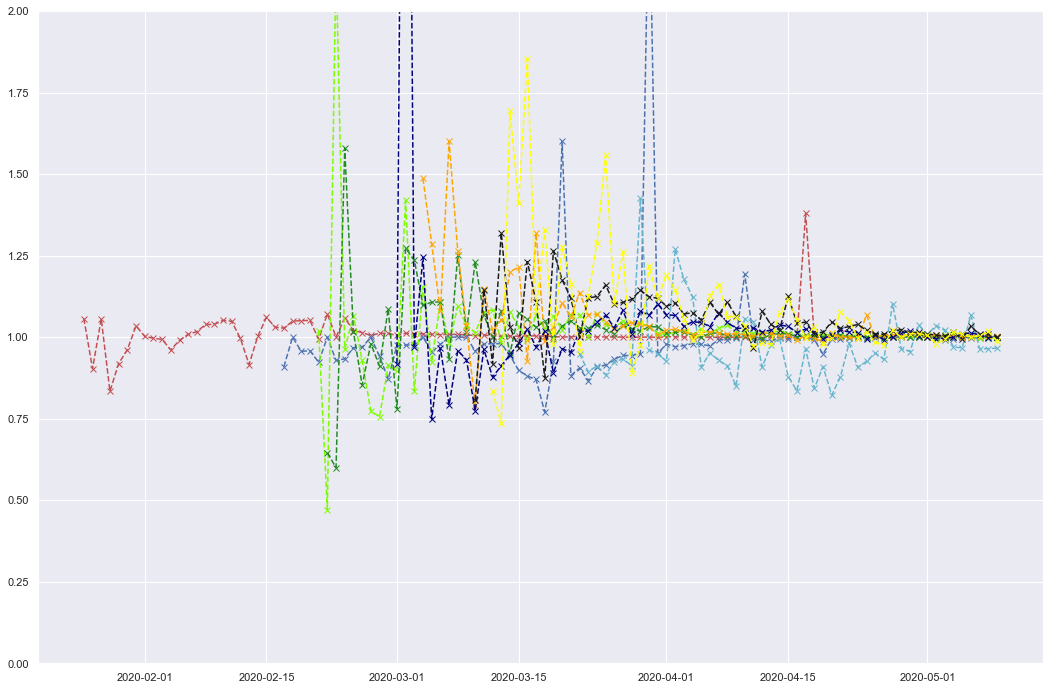

In [16]:
plt.figure(figsize=(18,12))
plt.ylim([0,2])
i = 0
for c in countries_of_interest:
    country = country_data[c]
    mask = country['deceased'] >= 1
    country = country[mask]
    plt.plot(country['dead_conf_ratio'],'x--',
             color=colors[i],label=c)
    i += 1 